<a href="https://colab.research.google.com/github/sebmatecho/deep_learning/blob/main/02_activities/assignments/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [1]:
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [2]:
class_names = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle",
    "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle",
    "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard",
    "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
    "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket",
    "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor",
    "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]

In [3]:
# Your Code Here
print(f'Training data shape. X_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'Testing data shape. X_test: {x_test.shape}, y_test: {y_test.shape}')

Training data shape. X_train: (50000, 32, 32, 3), y_train: (50000, 1)
Testing data shape. X_test: (10000, 32, 32, 3), y_test: (10000, 1)


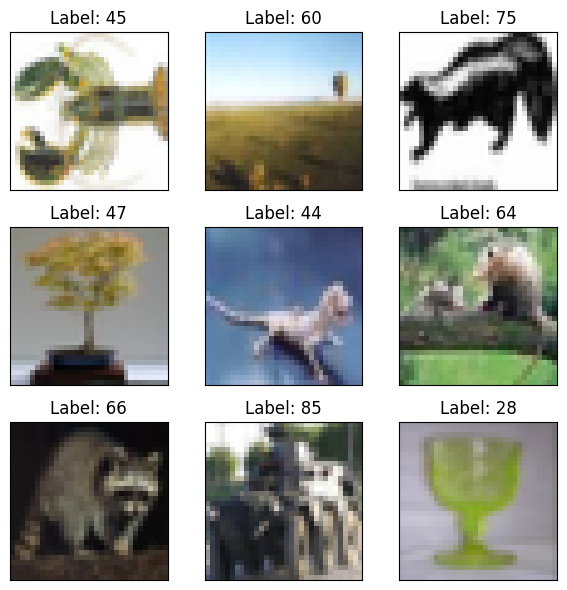

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Selecting 9 random indices from the training set
random_indices = np.random.choice(len(x_train), 9, replace=False)

# Creating a 3x3 grid plot
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[random_indices[i]])
    ax.set_title(f"Label: {y_train[random_indices[i]][0]}")

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### 1b: Data Preprocessing
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [5]:
# Your Code Here
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Normalizing images: after a visual inspection 255 was the largest value observed
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoded vectors
y_train = to_categorical(y_train, 100)
y_test  = to_categorical(y_test, 100)

# Split the training set into training and validation sets (80% training, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Optional: Display shapes to verify the splits
print("Training set shape:", x_train.shape, y_train.shape)
print("Validation set shape:", x_val.shape, y_val.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Training set shape: (40000, 32, 32, 3) (40000, 100)
Validation set shape: (10000, 32, 32, 3) (10000, 100)
Test set shape: (10000, 32, 32, 3) (10000, 100)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()

# First Convolution Block
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# Second Convolution Block
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))


# Flatten and Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,214,532 (8.45 MB)

 Trainable params: 2,214,532 (8.45 MB)

 Non-trainable params: 0 (0.00 B)

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different.
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> categorical_crossentropy
Based on my research, this loss function is ideal for multi-class classification problems where the targets are one-hot encoded, like this one.
- <b>Optimizer:</b> Adam is prefered because it adapts the learning rate for each parameter and incorporates momentum, leading to faster and more stable convergence during training.

In [21]:

model.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer='adam', # Optimizer
    metrics=['accuracy'] # Metrics to evaluate the model
)

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [22]:
history = model.fit(
    x_train, # Training data
    y_train, # Training labels
    epochs=20, # Number of epochs: Gotta start somewhere
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.0376 - loss: 4.3556 - val_accuracy: 0.1429 - val_loss: 3.6551
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1419 - loss: 3.6352 - val_accuracy: 0.2189 - val_loss: 3.2124
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2138 - loss: 3.2416 - val_accuracy: 0.2664 - val_loss: 2.9666
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2631 - loss: 2.9731 - val_accuracy: 0.2970 - val_loss: 2.8229
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3011 - loss: 2.7802 - val_accuracy: 0.3190 - val_loss: 2.7413
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3254 - loss: 2.6480 - val_accuracy: 0.3413 - val_loss: 2.6239
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3539 - loss: 2.4928 - val_accuracy: 0.3616 - val_loss: 2.5486
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3779 - loss: 2.3936 -

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> 38.59
- <b>Other metric:</b> F1 Score
- <b>Reason for selection:</b> The F1 score balances two key aspects of a model's predictions: precision, which measures how many of the predicted positive results are actually correct, and recall, which measures how many of the actual positives the model correctly identified. Instead of simply averaging these two measures, the F1 score uses their harmonic mean, which penalizes situations where one is much lower than the other
- <b>Value of metric:</b> 38.35
- <b>Interpretation of metric value:</b> the value is actually low so, it suggests the model struggles with correctly identifying the positive instances while minimizing both false positives and false negatives.

In [23]:
from sklearn.metrics import f1_score
import numpy as np

# Evaluate model on test set to get accuracy
test_loss, test_accuracy = model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Accuracy: {100*np.round(test_accuracy,4)}")

# Generate predictions for the test set
y_pred = model.predict(x_val)

# Convert predictions and true labels from one-hot to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate the macro F1 Score
f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"F1 Score: {100*(np.round(f1,4))}")


Validation Accuracy: 38.59
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
F1 Score: 38.35


### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

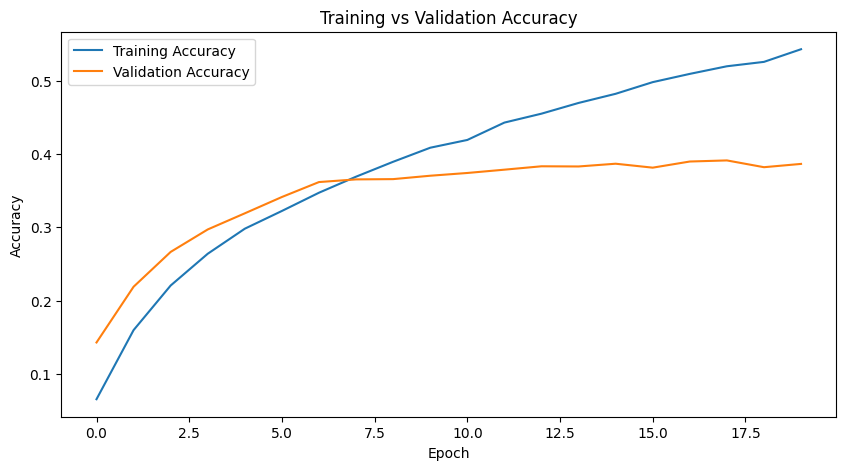

In [24]:
import numpy as np
import matplotlib.pyplot as plt


# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


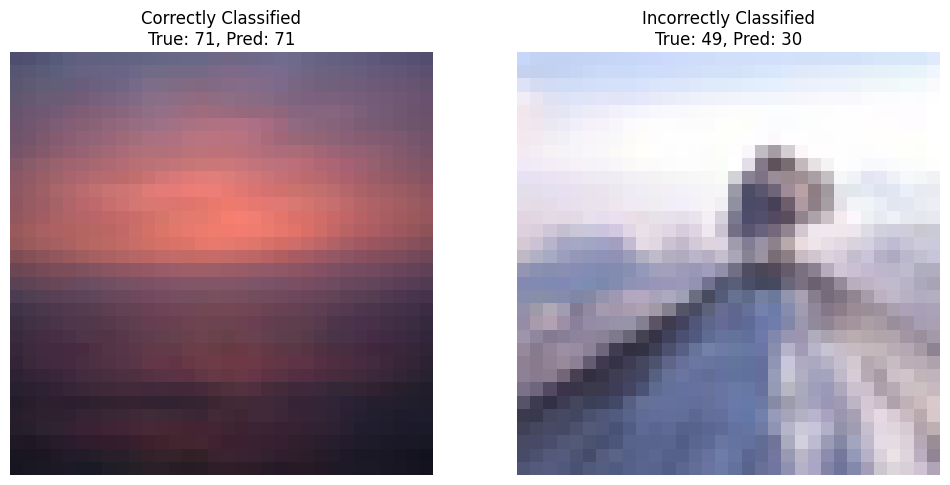

In [35]:

# Generate predictions for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


correct_indices = np.where(y_pred_classes == y_true)[0]
correct_index = correct_indices[0]

incorrect_indices = np.where(y_pred_classes != y_true)[0]
incorrect_index = incorrect_indices[0]

# Plot the selected images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_test[correct_index])
plt.title(f"Correctly Classified\nTrue: {y_true[correct_index]}, Pred: {y_pred_classes[correct_index]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_test[incorrect_index])
plt.title(f"Incorrectly Classified\nTrue: {y_true[incorrect_index]}, Pred: {y_pred_classes[incorrect_index]}")
plt.axis('off')

plt.show()

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

For this new model, we added another full third block of convolution layers and several batchnormalization layers. According to the research I conducted, this layers would standarize (using mean and standar deviation) the input data, allowing the learning process to stabilize as it takes care of the dynamics of internal correlations.

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model_2 = Sequential()

# First Convolution Block
model_2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

# Second Convolution Block
model_2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

# Third Convolution Block (Added for greater depth)
model_2.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.25))

# Flatten and Fully Connected Layers
model_2.add(layers.Flatten())
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(100, activation='softmax'))


model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,391,236 (5.31 MB)

 Trainable params: 1,389,316 (5.30 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

In [42]:

model_2.compile(
    loss='categorical_crossentropy', # Loss function
    optimizer='adam', # Optimizer
    metrics=['accuracy'] # Metrics to evaluate the model
)

In [43]:
history_2 = model_2.fit(
    x_train, # Training data
    y_train, # Training labels
    epochs=50, # Number of epochs: Choose this way so the targeted 55% accuracy can be reached.
    batch_size=32, # Number of samples per batch
    validation_split=0.2 # Use 20% of the data for validation
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.0696 - loss: 4.6840 - val_accuracy: 0.1874 - val_loss: 3.4763
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1916 - loss: 3.4173 - val_accuracy: 0.2269 - val_loss: 3.2038
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2794 - loss: 2.8639 - val_accuracy: 0.3363 - val_loss: 2.6132
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3409 - loss: 2.5527 - val_accuracy: 0.3389 - val_loss: 2.7464
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3927 - loss: 2.3327 - val_accuracy: 0.3893 - val_loss: 2.4002
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4226 - loss: 2.1660 - val_accuracy: 0.4270 - val_loss: 2.1983
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4561 - loss: 2.0386 - val_accuracy: 0.4016 - val_loss: 2.3702
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4822 - loss: 1.903

In [45]:
from sklearn.metrics import f1_score
import numpy as np

# Evaluate model on test set to get accuracy
test_loss, test_accuracy = model_2.evaluate(x_val, y_val, verbose=0)
print(f"Validation Accuracy: {100*np.round(test_accuracy,4)}")

# Generate predictions for the test set
y_pred = model_2.predict(x_val)

# Convert predictions and true labels from one-hot to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Calculate the macro F1 Score
f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f"F1 Score: {100*(np.round(f1,4))}")


Validation Accuracy: 54.71
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
F1 Score: 54.300000000000004


### Task 4c: Discussion of the results

- Briefly discuss the results.
- Did the model's performance improve?
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.

# Your answer here

The model improved reaching the 55% on accuracy on the validation set. Increasing the number of epochs, including several Batch Normalization layers and a new full third block of convolutional layers worked! I'm pretty sure there are improvement opportunities to the model. It took me hours to get to this results using a the tools on my toolbox, so I'm sure with other tools or combination of tools (such as data augmentation, more layers, more epochs and so), the model can certainly be improved.  

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.